# Separando datos de nombre y apellido en datos de nombre completo sin procesar

Es un escenario común encontrarse en el desarrollo de sistemas con conjuntos de datos que no han separado las columnas de nombre completo, por ejemplo, en `first_name` y `last_name`.
Tal es el caso del dataset con el que vamos a trabajar, que corresponde a las declaraciones juradas patrimoniales de funcionarios públicos de Argentina.
Es un escenario común de preprocesamiento de texto, por lo que vamos a usar técnicas comunes para tales escenarios: TfIdf y algoritmos de clustering para encontrar los grupos automáticamente.

## Instalamos pandas y scikit-learn

In [1]:
!pip install pandas scikit-learn hdbscan matplotlib tabulate

## Importamos los módulos de sklearn que vamos a usar:

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.base import clone


## Importamos pandas y cargamos el csv con declaraciones juradas

In [3]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/nmercado1986/jupyter-notebooks/master/ddjj.csv')

## Un pequeño vistazo:

In [4]:
print(df.head())

    dj_id         cuit  ...  ingresos_no_alcanzados_por_ig  bienes_heredados
0  400813  20120633725  ...                           0.00               0.0
1  356086  20148014370  ...                           0.00               0.0
2  378218  20148014370  ...                           0.00               0.0
3  382121  20141495357  ...                      274251.36               0.0
4  267754  20077510088  ...                      134688.81               0.0

[5 rows x 57 columns]


## De esto solo nos interesan los nombres:

Los queremos estandarizar en minúsculas. Además, vamos a sacar los stop-words del tipo:
- de: *De Achával, Fernández de Kirchner, el prefijo De no es necesario para determinar si es un apellido o nombre* 
- d'
- del
- de la
- y

In [5]:
df = df[df.tipo_declaracion_jurada_id==1]

import re
df['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre'].apply(lambda s: s.lower())
df['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre'].apply(lambda s: re.sub(r'\b(d|d\'|de|del|y|la)\b\s*', '', s))


## Separamos los nombres en 3 features distintos de acuerdo al 1er, 2do y 3er token

Para no tener que estar lidiando con problemas de tipo por `None` en esos casos donde no hay tercer token (gente sin nombre del medio), lo reemplazamos con un token `--SIN NOMBRE--`

In [6]:
dftrain = pd.DataFrame()
dftrain['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre']
dftrain['palabra0'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[0])
dftrain['palabra1'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[1])
dftrain['palabra2'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[2] if len(s.split(' ')) > 2 else "--SIN NOMBRE--")
dftrain['count'] = df['funcionario_apellido_nombre'].apply(lambda s: len(s.split(' ')))

###  Luego armamos un vocabulario con todos los nombres propios juntos. 
Este vocabulario se lo pasamos como parámetro a tf-idf.

In [7]:
todosLosNombres = pd.concat([dftrain['palabra0'], dftrain['palabra1'], dftrain['palabra2']], ignore_index=True).dropna().unique()
todosLosNombres = list(map(lambda s: s.lower(), todosLosNombres))

## Aplicando tf-idf y centrando features
Usamos tf-idf para calcular la frecuencia de cada nombre propio en cada una de las posiciones y en general en todo el listado de nombres

In [8]:
pipe = Pipeline([
    ('count', CountVectorizer(vocabulary=list(todosLosNombres))),
    ('idf', TfidfTransformer(norm=None, 
                             sublinear_tf=True, 
                             smooth_idf=True)),
    #('scaler', MaxAbsScaler())
])
pipe0 = clone(pipe)
pipe1 = clone(pipe)
pipe2 = clone(pipe)
pipe.fit(dftrain['funcionario_apellido_nombre'])
pipe0.fit(dftrain['palabra0'])
pipe1.fit(dftrain['palabra1'])
pipe2.fit(dftrain['palabra2'])

dftrain['tf_idf_palabra1'] = RobustScaler().fit_transform((
    np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1)).reshape(-1, 1))

dftrain['tf_idf_palabra1_in0'] = RobustScaler().fit_transform((
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1)).reshape(-1, 1))
dftrain['tf_idf_palabra1_in2'] = RobustScaler().fit_transform((
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1)).reshape(-1, 1))
dftrain['tf_idf_solo_dos'] = StandardScaler().fit_transform((dftrain['palabra2'] == "--SIN NOMBRE--").to_numpy().reshape(-1, 1))

# Algunos features que no vamos a extraer
#dftrain['tf_idf_palabra1'] = RobustScaler().fit_transform(np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra0_in1'] = StandardScaler().fit_transform(np.amax(pipe1.transform(dftrain['palabra0']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra0_in2'] = (np.amax(pipe2.transform(dftrain['palabra0']).toarray(), axis=1))

#dftrain['tf_idf_palabra1_comb_1_1'] = StandardScaler().fit_transform((dftrain['tf_idf_palabra1_in0'] / dftrain['tf_idf_palabra1_in2']).to_numpy().reshape(-1, 1))

#dftrain['tf_idf_palabra1_in1'] = RobustScaler().fit_transform(np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

#dftrain['tf_idf_palabra2_in0'] = StandardScaler().fit_transform(np.amax(pipe0.transform(dftrain['palabra2']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra2_in1'] = StandardScaler().fit_transform(np.amax(pipe1.transform(dftrain['palabra2']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra2_in2'] = StandardScaler().fit_transform(np.amax(pipe2.transform(dftrain['palabra2']).toarray(), axis=1).reshape(-1, 1))
dftrain['tf_count'] = StandardScaler().fit_transform(dftrain['count'].to_numpy().reshape(-1, 1))

#print((100 * dftrain['tf_idf_palabra1_in0'] / dftrain['tf_idf_palabra1_in2']).to_numpy().reshape(-1, 1))
dftrain['tf_idf_palabra1_comb_0_2'] = RobustScaler().fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain = dftrain[~dftrain.tf_idf_palabra1_in0.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_in2.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_comb_0_2.isna()]
dftrain.columns


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Index(['funcionario_apellido_nombre', 'palabra0', 'palabra1', 'palabra2',
       'count', 'tf_idf_palabra1', 'tf_idf_palabra1_in0',
       'tf_idf_palabra1_in2', 'tf_idf_solo_dos', 'tf_count',
       'tf_idf_palabra1_comb_0_2'],
      dtype='object')

## Por ejemplo, buscamos las filas con el nombre 'gomez'

En cada fila, obtenermos la frecuencia inversa del nombre 'gomez' dependiendo de dónde aparece el término. 
El indicador `tf_idf_palabra1_in0` nos muestra qué tan inusual es 'gomez' se encuentre en la primera posición.
El indicador `tf_idf_palabra1_in2` nos muestra qué tan inusual es que 'gomez' se encuentre en la tercera posición. 



In [60]:
dftrain[dftrain.funcionario_apellido_nombre.str.contains('gomez')].head(50)

,funcionario_apellido_nombre,palabra0,palabra1,palabra2,count,tf_idf_palabra1,tf_idf_palabra1_in0,tf_idf_palabra1_in2,tf_idf_solo_dos,tf_count,tf_idf_palabra1_comb_0_2,cluster
13848,corzo gomez clara isabel,corzo,gomez,clara,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
14140,criante gomez yesica ivonne,criante,gomez,yesica,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
16593,diaz gomez arturo leon,diaz,gomez,arturo,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
18765,farias gomez matias federico,farias,gomez,matias,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
19255,fernandez gomez rodrigo daniel,fernandez,gomez,rodrigo,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
21621,gallardo gomez felix gaston,gallardo,gomez,felix,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
22204,garcia gomez gonzalo antonio,garcia,gomez,gonzalo,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
23251,gil gomez maria eugenia,gil,gomez,maria,4,0.117665,-3.694009,2.514497,-0.307138,2.113781,-2.190563,3
23898,gomez adrian nestor,gomez,adrian,nestor,3,-0.035149,0.500000,-0.272950,-0.307138,-0.056709,0.580094,2
23899,gomez aguirre mauricio maximiliano,gomez,aguirre,mauricio,4,0.725953,-2.777294,2.514497,-0.307138,2.113781,-1.981675,3


# Agrupando usando KMeans

KMeans va a particionar nuestros datos, asignando obligadamente un cluster a cada elemento.




In [58]:
from sklearn.cluster import KMeans
#dbs = DBSCAN(eps=.25, min_samples=100)
#from sklearn.cluster import AgglomerativeClustering

dbs = KMeans(n_clusters=4)
#dbs = AgglomerativeClustering(n_clusters=2)
dbs.fit((dftrain.filter(regex='tf_.*')))
dftrain['cluster'] = dbs.labels_.astype(np.int)

print(dftrain[dftrain.cluster == -1])


Empty DataFrame
Columns: [funcionario_apellido_nombre, palabra0, palabra1, palabra2, count, tf_idf_palabra1, tf_idf_palabra1_in0, tf_idf_palabra1_in2, tf_idf_solo_dos, tf_count, tf_idf_palabra1_comb_0_2, cluster]
Index: []


## Previsualizamos nuestros grupos

HDBSCAN nos va a devolver un ID de cluster por fila. Veamos cuántos elementos tiene cada clúster, y la cantidad total de clústeres encontrados.
El clúster -1 corresponde a los outliers.

In [59]:
print(dftrain['cluster'].value_counts())
print(dftrain['cluster'].max())

2    20291
0    15137
3     4964
1     3811
Name: cluster, dtype: int64
3


**Luego importamos `matplotlib` para visualizar los grupos que se formaron sobre el componente extraído.**

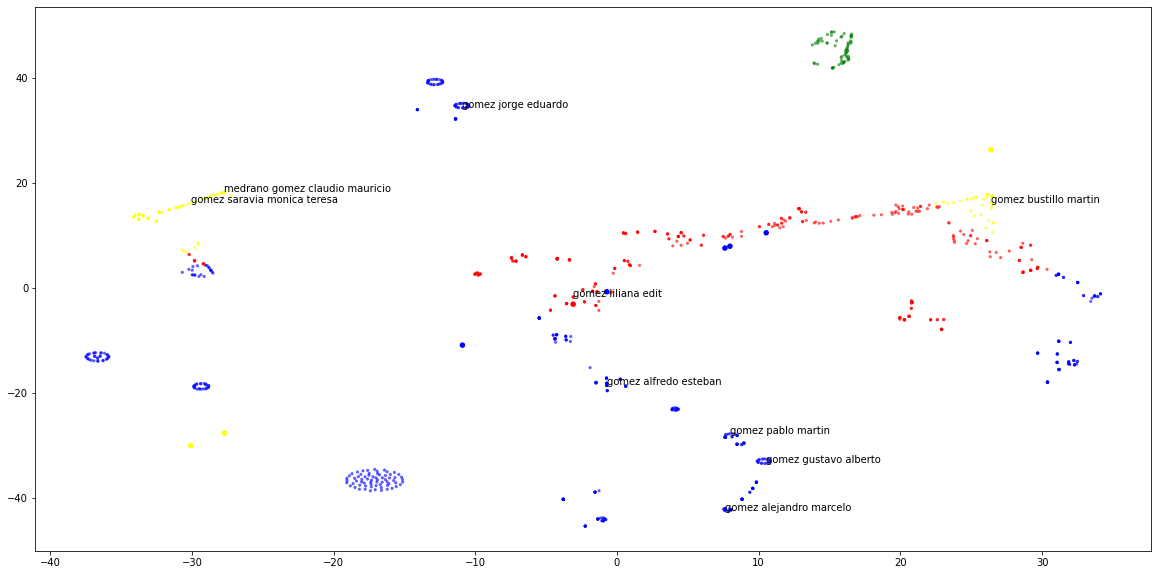

In [79]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams['figure.figsize'] = [20, 10]


fig = plt.figure()

def plotApellidos(dftrain, apellido, ax):
    """ Plotea los nombres de un apellido vs la totalidad del dataset en 2d
    """
    dfsample = dftrain.sample(1000)
    colors = ['red', 'green', 'blue', 'yellow', 'pink', 'orange']
        
    """ TSNE tarda mucho con muestras grandes """
    tsne = TSNE(n_iter=1000)
    proj = tsne.fit_transform(dfsample.filter(regex = 'tf_.*'))
    dfsample['tsne0'] = proj[:,0]
    dfsample['tsne1'] = proj[:,1]

    dfApellido = dfsample[dfsample.funcionario_apellido_nombre.str.contains(apellido)]


    
    #projApellido = tsne.fit_transform(dfApellido.filter(regex = 'tf_.*'))
    #dfApellido['pca0'] = projApellido[:,0]
    #dfApellido['pca1'] = projApellido[:,1]
    
    ax.scatter(dfsample['tsne0'], dfsample['tsne1'], alpha=.5, s=5, c= dfsample['cluster'].apply(lambda i: colors[ i % len(colors) ]))
    ax.scatter(dfApellido['tsne0'], dfApellido['tsne0'], s=20, c= dfApellido['cluster'].apply(lambda i: colors[ i % len(colors) ]))

    for id, row in dfApellido.iterrows():
        ax.annotate(row['funcionario_apellido_nombre'], (row['tsne0'], row['tsne1']))


    plt.show()
    
    
 

plotApellidos(dftrain, 'gomez', fig.add_subplot('111'))

Veamos cómo fue catalogado cada uno de los Gómez.
A partir del gráfico, podemos ver que aquellos `Gómez` donde este apellido es uno de varios están en el grupo más a la izquierda del eje X
Incluso, vemos el caso de `Gómez Albano Emmanuel`, lo que tiene sentido porque el nombre propio `Albano` es difícil de identificar como nombre o como apellido.
El usar un sólo componente nos permitió establecer una diferencia muy tajante.
Un apellido o muchos, sin especificar demasiado pequeñas agrupaciones como si los nombres tienen 2 o 3 palabras, si son de apellidos comunes o poco comunes, etc. Sólo 65 elementos no fueron reconocidos.

Como vemos, los Gómez quedaron separados en los dos grupos que queríamos: **aquelles con un solo apellido** y **aquelles con dos**.
Las filas de doble apellido pertenecen al cluster 0, tanto en los casos donde Gómez era el primer apellido (Gómez Alcaraz, Gómez Aguirre) como cuando era el segundo (Gil Gómez, Díaz Gómez).


In [80]:
dfgomez = dftrain[dftrain.funcionario_apellido_nombre.str.contains('gomez')]
dfgomez[['funcionario_apellido_nombre', 'cluster']].head(50)

,funcionario_apellido_nombre,cluster
13848,corzo gomez clara isabel,3
14140,criante gomez yesica ivonne,3
16593,diaz gomez arturo leon,3
18765,farias gomez matias federico,3
19255,fernandez gomez rodrigo daniel,3
21621,gallardo gomez felix gaston,3
22204,garcia gomez gonzalo antonio,3
23251,gil gomez maria eugenia,3
23898,gomez adrian nestor,2
23899,gomez aguirre mauricio maximiliano,3


### Otros apellidos

Todo muy bien con los Gómez, quedaron bien catalogados, pero veamos otros apellidos, comunes y no tanto.
Veamos por ejemplo el apellido `Acevedo`, un poco menos común.

In [81]:

dfacevedo = dftrain[dftrain.funcionario_apellido_nombre.str.contains('acevedo')]
dfacevedo[['funcionario_apellido_nombre', 'cluster']]

,funcionario_apellido_nombre,cluster
219,acevedo alberto enrique,2
223,acevedo arnaldo daniel,0
224,acevedo barbara yanel,0
225,acevedo carlos adrian,2
226,acevedo cesar alberto,2
227,acevedo daniel alberto jesus,2
228,acevedo delia beatriz,0
230,acevedo diaz eduardo alejandro,3
231,acevedo eduardo horacio,2
232,acevedo gabriel esteban,2


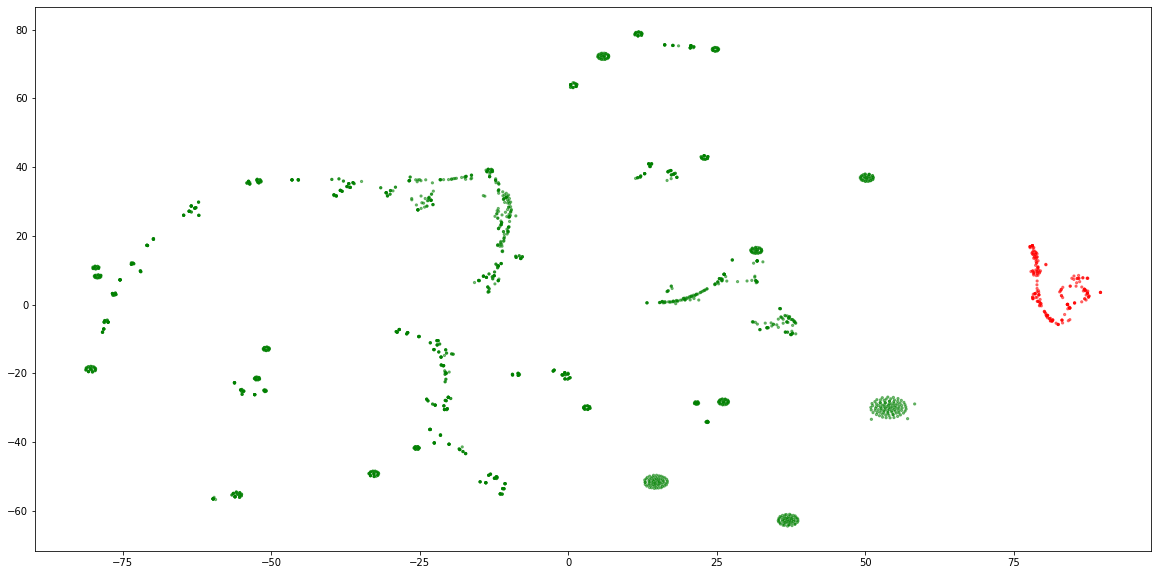

In [15]:
plotApellidos(dftrain, dfacevedo.tail(20), plt.figure().add_subplot('111'))

In [16]:
dfpereyra = dftrain[dftrain.funcionario_apellido_nombre.str.contains('pereyra')].head(50)
dfpereyra[['funcionario_apellido_nombre', 'cluster']]

,funcionario_apellido_nombre,cluster
18782,farias pereyra nestor emiliano,1
19508,fernandez pereyra miguel aquiles,1
40850,pereyra agustin andr,1
40851,pereyra alejandro fabio,1
40852,pereyra ana laura,1
40853,pereyra ana teresa,1
40854,pereyra ariel,0
40855,pereyra ariel manuel,1
40857,pereyra armando horacio,1
40858,pereyra atilio ruben,1


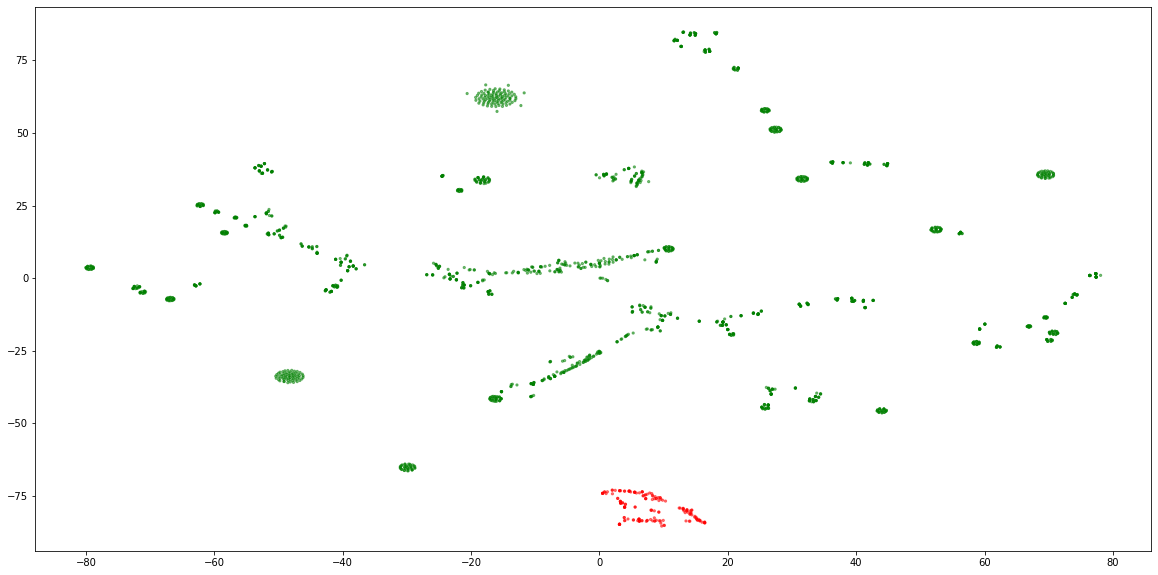

In [17]:
plotApellidos(dftrain, dfpereyra, plt.figure().add_subplot('111'))

**Finalmente, exportamos los dos grupos por separado, uno para la gente con doble apellido y otro para la gente con uno solo:**

In [18]:
dftrain[dftrain.cluster == 0].to_csv('doble_apellido.csv')
dftrain[dftrain.cluster == 1].to_csv('un_apellido.csv')

Los archivos están disponibles para descargar en el notebook con el nombre de [un_apellido.csv](/edit/un_apellido.csv) y [doble_apellido.csv](/edit/doble_apellido.csv).